In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import time_series_preprocessor as tsp
import matplotlib.pyplot as plt
from tensorflow.python.ops import metrics_impl

from tensorflow.python.framework import ops
import warnings
import random
import os

warnings.filterwarnings("ignore")
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
tf.logging.set_verbosity(tf.logging.ERROR)
ops.reset_default_graph()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Using LSTM RNNs for Time Series Prediction

#### The repeating module in a standard RNN has just a single layer
<img src='../pics/SimpleRNN_layer.png'>

#### The repeating module in an LSTM has four interacting layers
<img src='../pics/LSTM_layer.png'>

<img src='../pics/LSTM_notation.png'>

In [2]:
# Hyperparameters
input_dim = 1
seq_size = 5
hidden_dim = 5

# Weight variables and input placeholders
#W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
W_out = tf.get_variable("W_out", shape=[hidden_dim, 1], dtype=tf.float32, initializer=None, regularizer=None, trainable=True, collections=None)

# b_out = tf.Variable(tf.random_normal([1]), name='b_out')
b_out = tf.get_variable("b_out", shape=[1], dtype=tf.float32, initializer=None, regularizer=None, trainable=True, collections=None)

x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
y = tf.placeholder(tf.float32, [None, seq_size])

In [3]:
def LSTM_Model():
        """
        :param x: inputs of size [T, batch_size, input_size]
        :param W: matrix of fully-connected output layer weights
        :param b: vector of fully-connected output layer biases
        """
        cell = rnn_cell.BasicLSTMCell(hidden_dim)
        outputs, states = rnn.dynamic_rnn(cell, x, dtype=tf.float32)
        num_examples = tf.shape(x)[0]
        W_repeated = tf.tile(tf.expand_dims(W_out, 0), [num_examples, 1, 1])
        out = tf.matmul(outputs, W_repeated) + b_out
        out = tf.squeeze(out)
        return out

train_loss = []
test_loss = []
step_list = []

In [4]:
def trainNetwork(train_x, train_y, test_x, test_y):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            max_patience = 3
            patience = max_patience
            min_test_err = float('inf')
            step = 0
            while patience > 0:
                _, train_err = sess.run([train_op, cost], feed_dict={x: train_x, y: train_y})
                if step % 100 == 0:
                    test_err = sess.run(cost, feed_dict={x: test_x, y: test_y})
                    print('step: {}\t\ttrain err: {:.3f}\t\ttest err: {:.2f}'.format(step, train_err, test_err))
                    train_loss.append(train_err)
                    test_loss.append(test_err) 
                    step_list.append(step)                   

                    if test_err < min_test_err:
                        min_test_err = test_err
                        patience = max_patience
                    else:
                        patience -= 1
                step += 1                
            save_path = saver.save(sess, 'model/model.ckpt')
            print('Model saved to {}'.format(save_path))

# Cost optimizer
cost = tf.reduce_mean(tf.square(LSTM_Model()- y))
train_op = tf.train.AdamOptimizer(learning_rate=0.003).minimize(cost)

# Auxiliary ops
saver = tf.train.Saver()
def testLSTM(sess, test_x):
        tf.get_variable_scope().reuse_variables()
        saver.restore(sess, 'model/model.ckpt')
        output = sess.run(LSTM_Model(), feed_dict={x: test_x})
        return output

def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

In [5]:
data = tsp.load_series('../data/international-airline-passengers.csv')
train_data, actual_vals = tsp.split_data(data=data, percent_train=0.75)

In [6]:
import pandas as pd
df = pd.read_csv('../data/international-airline-passengers.csv',header=None)
df.head()

,0,1
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
train_x, train_y = [], []
for i in range(len(train_data) - seq_size - 1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1])

test_x, test_y = [], []
for i in range(len(actual_vals) - seq_size - 1):
    test_x.append(np.expand_dims(actual_vals[i:i+seq_size], axis=1).tolist())
    test_y.append(actual_vals[i+1:i+seq_size+1])

step: 0		train err: 4.709		test err: 0.55
step: 100		train err: 1.036		test err: 0.56
step: 200		train err: 0.372		test err: 0.44
step: 300		train err: 0.211		test err: 0.41
step: 400		train err: 0.111		test err: 0.41
step: 500		train err: 0.071		test err: 0.41
step: 600		train err: 0.053		test err: 0.40
step: 700		train err: 0.048		test err: 0.38
step: 800		train err: 0.046		test err: 0.37
step: 900		train err: 0.045		test err: 0.35
step: 1000		train err: 0.044		test err: 0.33
step: 1100		train err: 0.043		test err: 0.32
step: 1200		train err: 0.043		test err: 0.30
step: 1300		train err: 0.042		test err: 0.28
step: 1400		train err: 0.041		test err: 0.27
step: 1500		train err: 0.041		test err: 0.26
step: 1600		train err: 0.040		test err: 0.25
step: 1700		train err: 0.039		test err: 0.25
step: 1800		train err: 0.039		test err: 0.25
step: 1900		train err: 0.039		test err: 0.25
step: 2000		train err: 0.038		test err: 0.25
step: 2100		train err: 0.038		test err: 0.25
Model saved to model/m

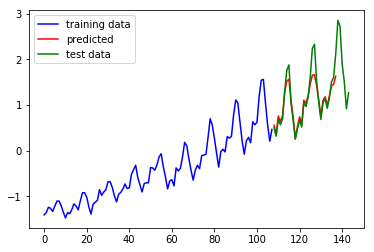

In [8]:
trainNetwork(train_x, train_y, test_x, test_y)

with tf.Session() as sess:
    predicted_vals = testLSTM(sess, test_x)[:,0]
    #print('predicted_vals', np.shape(predicted_vals))
    # Following prediction results of the model given ground truth values
    plot_results(train_data, predicted_vals, actual_vals, 'ground_truth_predition.png')

    prev_seq = train_x[-1]
    predicted_vals = []
    for i in range(100):
        next_seq = testLSTM(sess, [prev_seq])
        predicted_vals.append(next_seq[-1])
        prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))

#     # Following predictions results where only the training data was given
#     plot_results(train_data, predicted_vals, actual_vals, 'prediction_on_train_set.png')

In [9]:
def plot_error():
	# Plot loss over time
	plt.plot(step_list, train_loss, 'r--', label='LSTM training loss per iteration', linewidth=4)
	plt.title('LSTM training loss per iteration')
	plt.xlabel('Iteration')
	plt.ylabel('Training loss')
	plt.legend(loc='upper right')
	plt.show()

	# Plot accuracy over time
	plt.plot(step_list, test_loss, 'r--', label='LSTM test loss per iteration', linewidth=4)
	plt.title('LSTM test loss per iteration')
	plt.xlabel('Iteration')
	plt.ylabel('Test loss')
	plt.legend(loc='upper left')
	plt.show()

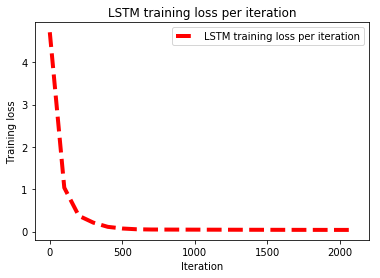

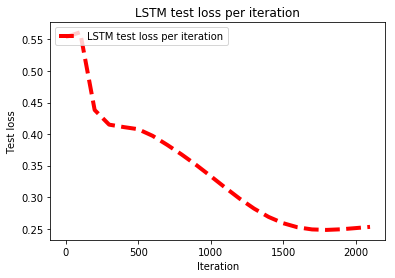

In [10]:
plot_error()